In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import matplotlib.colors as colors
import h5py
import nbimporter
from _create_pdf import create_spins;
from _helper_functions import tsallis, cauchy, find_nearest, odeintz, find_nearest_sorted_left
from _steady_state import a_steady
from _mbes import mbes, mbes_soc
from _do_calculation import solve_mbes
#%qtconsole

Importing Jupyter notebook from _create_pdf.ipynb
Importing Jupyter notebook from _helper_functions.ipynb
Importing Jupyter notebook from _steady_state.ipynb
Importing Jupyter notebook from _mbes.ipynb
Importing Jupyter notebook from _do_calculation.ipynb


In [2]:
gcoll = 2*np.pi #HWHM
q = 1.39
quali = 800
fr = 3.2981e3;
kappa = np.pi*fr/quali #HWHM
delta = 0*2*np.pi #detuning cavity to spin central frequency ws-wc
deltac = 0*2*np.pi #detuning drive to cavity wc-wp
gperp = 2*np.pi*0.09 #HWHM
gpar = 2*np.pi*.001#0.001 #HWHM
gammaq = 2*np.pi*2 #FWHM
nbins = 701#701#5000#20
#g0 = gcoll/sqrt(nspins)
print(kappa)

12.951608413505621


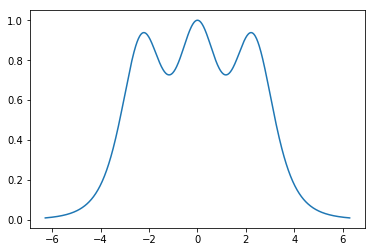

In [3]:
spins, gs, pdf = create_spins(gcoll, q, delta, gammaq, nbins, holes=False, inhomo=True, hyperfine=True)
plt.plot(spins, pdf/max(pdf))

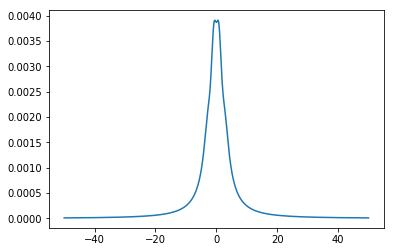

In [4]:
initsteady = (0.1,0.1)
fstart = 50
deltaarr = np.linspace(-fstart*2*np.pi,fstart*2*np.pi, 2000)
etasteady = 0.00001
losasteady = np.zeros(np.shape(deltaarr))
losareal = np.zeros(np.shape(deltaarr))
losaimag = np.zeros(np.shape(deltaarr))

newinit = initsteady
for i, delt in enumerate(deltaarr):
    ar, ai = a_steady(etasteady, delt, gs, spins, gpar, gperp, kappa, newinit)
    newinit = (ar, ai)
    losasteady[i] = ai**2+ar**2
    losareal[i] = ar
    losaimag[i] = ai

fig = plt.figure()
plt.plot(deltaarr/2/np.pi, (losasteady/0.0000000001))
#deltaarr[find(losasteady == max(losasteady))]/2/pi

# SOC pulses

In [5]:
decaytime = 900e-3
dt = 4e-3
tlistdecay = np.arange(0, decaytime+dt, dt)
scale = 1
init = np.ones(nbins*2+1)*(-1)
init[0] = 0
init[1::2] = 0

In [6]:
filename = '/mnt/measure/2016/20180816_MeasurementRun108/20180829_1000_genetic_test/genetic_new.mat'
data = scipy.io.loadmat(filename)
ilist = data['puls'][:,1]*scale
qlist = data['puls'][:,2]*scale
tlist = data['puls'][:,0]
scale = 0.0001

In [11]:
solpump, soldecay, infodict = solve_mbes(mbes_soc, init, pdf, tlist, tlistdecay, ilist, qlist, tlist, kappa, deltac, gs, gperp, spins, gpar)
a2pump = solpump[:,0]
a2decay = soldecay[:,0]

In [12]:
dataexp = scipy.io.loadmat('/mnt/measure/2016/20180816_MeasurementRun108/20180831_genetic_tes2/data.mat')
datalin = dataexp['data'][0][0][0][0][4]
imeas = datalin[2]-np.mean(datalin[2][3500:4000])
qmeas = datalin[3]-np.mean(datalin[3][3500:4000])
a2exp = (imeas**2+qmeas**2)
texp = datalin[0]

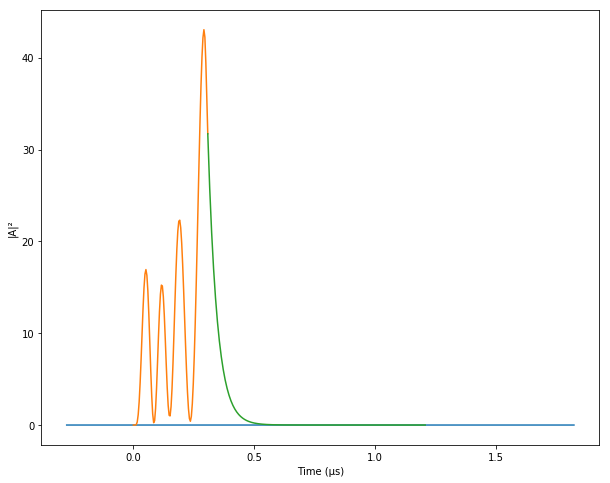

In [13]:
idxstart = 800
idx = 5000
plt.figure(figsize=(10,8))
plt.plot(np.squeeze(texp)[idxstart:idx]*1e6-0.676, 35e-5*np.squeeze(((1*imeas)**2+(qmeas)**2))[idxstart:idx])
plt.plot(tlist, abs(a2pump)**2, tlistdecay+tlist[-1], abs(a2decay)**2)
plt.xlabel('Time (µs)')
plt.ylabel('|A|²');

## Compare with data

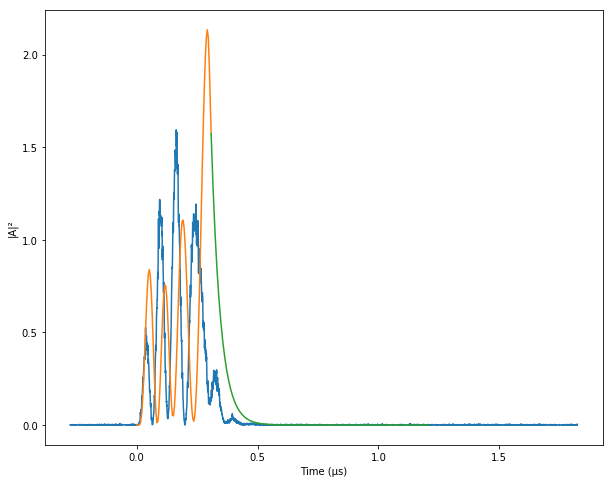

In [14]:
datalin = dataexp['data'][0][0][0][0]
pin = np.arange(-30, 1, 1)
aref = 0.79
ain = aref*10**(pin/20)
texp = np.squeeze(datalin[0][0])[idxstart:idx]*1e6-0.676
plt.figure(figsize=(10,8))
plt.xlabel('Time (µs)')
plt.ylabel('|A|²');
for i, dat in enumerate(datalin):
    if i != len(datalin)-12: continue
    imeas = dat[2]-np.mean(dat[2][3500:4000])
    qmeas = dat[3]-np.mean(dat[3][3500:4000])
    a2exp = (imeas**2+qmeas**2)
    expdat = np.squeeze(a2exp[idxstart:idx])*0.5e2
    
    
    ilist, qlist, tlist, kappa, deltac, gs, gperp, spins, gpar
    
    asolpump, asoldecay, infodict = solve_mbes(mbes_soc, init, pdf, tlist, tlistdecay, ilist*ain[i], qlist*ain[i],tlist, kappa, deltac, gs, gperp, spins, gpar)
    plt.plot(texp, expdat)
    a2pump = asolpump[:,0]
    a2decay = asoldecay[:,0]
    plt.plot(tlist, abs(a2pump)**2, tlistdecay+tlist[-1], abs(a2decay)**2)